# 1. Setup

In [5]:
!python -m pip install --upgrade pip

  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [6]:
!pip install setuptools wheel

In [17]:
!pip install typing_extensions==3.7.4
!pip install aiosqlite==0.17.0

  Using cached typing_extensions-3.7.4-py3-none-any.whl.metadata (1.9 kB)
Using cached typing_extensions-3.7.4-py3-none-any.whl (20 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiosqlite 0.18.0 requires typing_extensions>=4.0; python_version < "3.8", but you have typing-extensions 3.7.4 which is incompatible.


  Attempting uninstall: aiosqlite
    Found existing installation: aiosqlite 0.18.0
    Uninstalling aiosqlite-0.18.0:
      Successfully uninstalled aiosqlite-0.18.0


## 1.1 Install Dependencies

In [18]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [107]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [108]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [109]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [110]:
len(gpus)


0

## 1.4 Create Folder Structures

In [111]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [26]:
# http://vis-www.cs.umass.edu/lfw/

In [5]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [146]:
# Import uuid library to generate unique image names
import uuid

In [147]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4a485f46-d922-11ef-82bc-50ebf68d4469.jpg'

In [148]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positivesq
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcamq
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

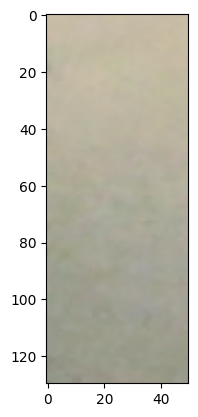

In [149]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [196]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [198]:
len(anchor)

300

In [199]:
dir_test = anchor.as_numpy_iterator()

In [200]:
print(dir_test.next())

b'data\\anchor\\faaaa4ee-d90a-11ef-a736-50ebf68d4469.jpg'


## 3.2 Preprocessing - Scale and Resize

In [201]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [202]:
img = preprocess(dir_test.next())

In [203]:
img.numpy().max() 

0.89436275

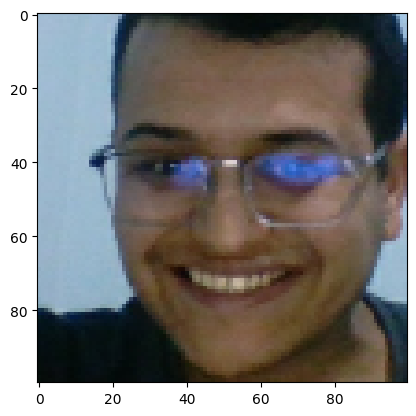

In [204]:
plt.imshow(img)

In [205]:
#dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [206]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [242]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [243]:
len(data)

600

In [244]:
samples = data.as_numpy_iterator()

In [245]:
exampple = samples.next()

In [246]:
exampple

(b'data\\anchor\\fc024a06-d90a-11ef-bd2e-50ebf68d4469.jpg',
 b'data\\positive\\013102d8-d90b-11ef-a0c3-50ebf68d4469.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [247]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [248]:
res = preprocess_twin(*exampple)

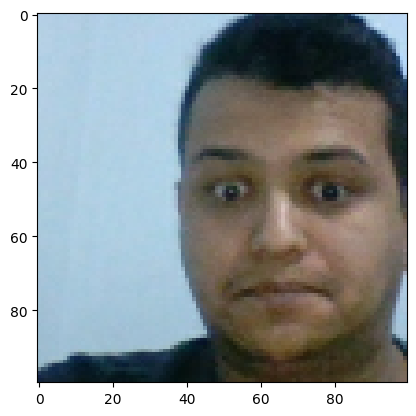

In [249]:
plt.imshow(res[1])

In [250]:
res[2]

1.0

In [251]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [252]:
len(data)

600

In [253]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [254]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [257]:
len(train_data)

27

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [258]:
inp = Input(shape=(100,100,3), name='input_image')

In [259]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [260]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [261]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [262]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [263]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [264]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [265]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 128)         0 

In [266]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [267]:
embedding = make_embedding()

In [268]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [269]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [270]:
l1 = L1Dist()

In [271]:
#l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [272]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [273]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [274]:
siamese_layer = L1Dist()

In [275]:
distances = siamese_layer(inp_embedding, val_embedding)

In [276]:
classifier = Dense(1, activation='sigmoid')(distances)

In [277]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [278]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [279]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_8 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [280]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [281]:
siamese_model = make_siamese_model()

In [282]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [283]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [284]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [285]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [286]:
test_batch = train_data.as_numpy_iterator()

In [287]:
batch_1 = test_batch.next()

In [288]:
X = batch_1[:2]

In [289]:
y = batch_1[2]

In [290]:
y

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [291]:
tf.losses.BinaryCrossentropy??

In [292]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    tf.print("Loss: ", loss)  # Use tf.print for TensorFlow graph execution
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [293]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        # Calculate the number of steps per epoch
        steps_per_epoch = len(data) 
        
        progbar = tf.keras.utils.Progbar(steps_per_epoch) 
                
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [294]:
EPOCHS = 50

In [295]:
train(train_data, EPOCHS)


 Epoch 1/50
Loss:  0.692153633
27/27 [==============================] - 397s 15s/step

 Epoch 2/50
Loss:  0.130458951
27/27 [==============================] - 381s 14s/step

 Epoch 3/50
Loss:  0.0910523683
27/27 [==============================] - 381s 14s/step

 Epoch 4/50
Loss:  0.682814777
27/27 [==============================] - 379s 14s/step

 Epoch 5/50
Loss:  0.0314434431
 9/27 [=========>....................] - ETA: 4:17Loss:  0.0151171368


27/27 [==============================] - 374s 14s/step

 Epoch 6/50
Loss:  0.00334386458
27/27 [==============================] - 378s 14s/step

 Epoch 7/50
Loss:  0.00263160956
27/27 [==============================] - 381s 14s/step

 Epoch 8/50
Loss:  0.00058908324
27/27 [==============================] - 1190s 45s/step

 Epoch 9/50
Loss:  0.643996119
18/27 [===================>..........] - ETA: 2:22Loss:  0.400709331


27/27 [==============================] - 414s 15s/step

 Epoch 10/50
Loss:  0.423123896
27/27 [==============================] - 412s 15s/step

 Epoch 11/50
Loss:  0.289873421
27/27 [==============================] - 414s 15s/step

 Epoch 12/50
Loss:  0.453796983
27/27 [==============================] - 1929s 17s/step

 Epoch 13/50
Loss:  0.0481841341
27/27 [==============================] - 433s 16s/step

 Epoch 14/50
Loss:  0.0546981655


27/27 [==============================] - 440s 16s/step

 Epoch 15/50
Loss:  0.00377246412
27/27 [==============================] - 425s 16s/step

 Epoch 16/50
Loss:  0.105161659
27/27 [==============================] - 441s 16s/step

 Epoch 17/50
Loss:  0.0578439683
27/27 [==============================] - 441s 16s/step

 Epoch 18/50
Loss:  2.20258662e-05
 8/27 [=======>......................] - ETA: 5:20Loss:  0.141555652


27/27 [==============================] - 441s 16s/step

 Epoch 19/50
Loss:  0.0686458722
27/27 [==============================] - 440s 16s/step

 Epoch 20/50
Loss:  0.0435513072
27/27 [==============================] - 481s 18s/step

 Epoch 21/50
Loss:  0.00879133
27/27 [==============================] - 491s 18s/step

 Epoch 22/50
Loss:  0.00374975638
15/27 [===============>..............] - ETA: 3:36Loss:  0.0212189127


27/27 [==============================] - 468s 17s/step

 Epoch 23/50
Loss:  0.0137936668
27/27 [==============================] - 451s 17s/step

 Epoch 24/50
Loss:  0.00281127938
27/27 [==============================] - 447s 17s/step

 Epoch 25/50
Loss:  0.026204396
27/27 [==============================] - 453s 17s/step

 Epoch 26/50
Loss:  0.033656396
23/27 [========================>.....] - ETA: 1:10Loss:  0.389769018


27/27 [==============================] - 461s 17s/step

 Epoch 27/50
Loss:  0.0196106527
27/27 [==============================] - 452s 17s/step

 Epoch 28/50
Loss:  0.688614964
27/27 [==============================] - 452s 17s/step

 Epoch 29/50
Loss:  0.339624107
27/27 [==============================] - 452s 17s/step

 Epoch 30/50
Loss:  0.0387600511
27/27 [==============================] - 454s 17s/step

 Epoch 31/50
Loss:  0.0517741255
 4/27 [===>..........................] - ETA: 6:46Loss:  0.0331815


27/27 [==============================] - 459s 17s/step

 Epoch 32/50
Loss:  0.00494453497
27/27 [==============================] - 458s 17s/step

 Epoch 33/50
Loss:  7.21529941e-05
27/27 [==============================] - 461s 17s/step

 Epoch 34/50
Loss:  0.00525258761
27/27 [==============================] - 457s 17s/step

 Epoch 35/50
Loss:  9.13740951e-05
11/27 [===========>..................] - ETA: 4:36Loss:  0.00978386


27/27 [==============================] - 457s 17s/step

 Epoch 36/50
Loss:  0.0100727268
27/27 [==============================] - 459s 17s/step

 Epoch 37/50
Loss:  0.00302953459
27/27 [==============================] - 459s 17s/step

 Epoch 38/50
Loss:  0.0451549962
27/27 [==============================] - 460s 17s/step

 Epoch 39/50
Loss:  0.000620841223
17/27 [=================>............] - ETA: 2:54Loss:  0.000437920826


27/27 [==============================] - 458s 17s/step

 Epoch 40/50
Loss:  0.00129190553
27/27 [==============================] - 463s 17s/step

 Epoch 41/50
Loss:  0.00162745814
27/27 [==============================] - 451s 17s/step

 Epoch 42/50
Loss:  0.000582553097
27/27 [==============================] - 453s 17s/step

 Epoch 43/50
Loss:  0.00217606919
24/27 [=========================>....] - ETA: 51s Loss:  0.00123809


27/27 [==============================] - 453s 17s/step

 Epoch 44/50
Loss:  0.00157709094
27/27 [==============================] - 451s 17s/step

 Epoch 45/50
Loss:  0.0099653136
27/27 [==============================] - 452s 17s/step

 Epoch 46/50
Loss:  0.00050747249
27/27 [==============================] - 452s 17s/step

 Epoch 47/50
Loss:  0.000577544619
27/27 [==============================] - 453s 17s/step

 Epoch 48/50
Loss:  7.60217299e-05
 3/27 [==>...........................] - ETA: 6:40Loss:  2.77164827e-06


27/27 [==============================] - 451s 17s/step

 Epoch 49/50
Loss:  0.00360850734
27/27 [==============================] - 451s 17s/step

 Epoch 50/50
Loss:  0.0018209524
27/27 [==============================] - 451s 17s/step


# 6. Evaluate Model

## 6.1 Import Metrics

In [296]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [297]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [306]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.0000000e+00],
       [9.8510402e-01],
       [9.3038422e-01],
       [1.0000000e+00],
       [9.9740797e-01],
       [4.4901729e-13],
       [9.9998796e-01],
       [9.8781234e-01],
       [1.0000000e+00],
       [1.1112185e-06],
       [9.9972546e-01],
       [9.9982762e-01],
       [9.9946082e-01],
       [2.2973294e-05],
       [2.9830527e-11],
       [1.2434688e-06]], dtype=float32)

In [308]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]

In [309]:
y_true

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [311]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [312]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

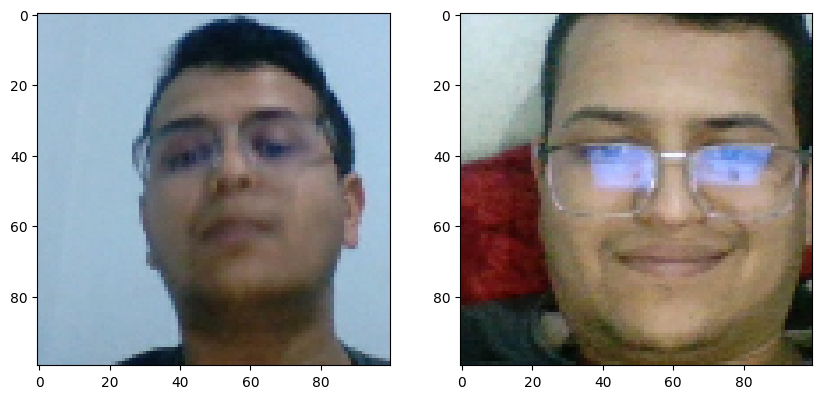

In [313]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [314]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [315]:
L1Dist

__main__.L1Dist

In [319]:
from tensorflow.keras.models import load_model

# Reload model 
#model = tf.keras.models.load_model('siamesemodel.h5', 
#                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
# Load the saved model
model = load_model('siamesemodel.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.keras.losses.BinaryCrossentropy})


In [317]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[1.0000000e+00],
       [9.8510402e-01],
       [9.3038422e-01],
       [1.0000000e+00],
       [9.9740797e-01],
       [4.4901729e-13],
       [9.9998796e-01],
       [9.8781234e-01],
       [1.0000000e+00],
       [1.1112185e-06],
       [9.9972546e-01],
       [9.9982762e-01],
       [9.9946082e-01],
       [2.2973294e-05],
       [2.9830527e-11],
       [1.2434688e-06]], dtype=float32)

In [320]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_12 (L1Dist)             (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [162]:
#application_data\verification_images

In [321]:
VI = os.path.join('application_data', 'verification_images')
II = os.path.join('application_data', 'input_image')

In [9]:
#os.makedirs(VI)
#os.makedirs(II)

In [322]:
os.listdir(os.path.join('application_data', 'verification_images'))

[]

In [101]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [323]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [324]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [328]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

C:\Users\ismai\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  


False
False
False
False
False
False
False
False
False
False
False
False
False


In [326]:
np.sum(np.squeeze(results) > 0.9)

0

In [327]:
32/50

0.64